### 0. Imports necesarios

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD

import lightgbm as lgb
import os
import dill


### 1. Carga de datos de Train

In [17]:
df_train = pd.read_csv('../data/train.csv', index_col=0)

# Ponemos 'id' como índice
df_train = df_train.set_index('id')

### 2. Mini EDA

In [18]:
# Visualización de nulos
df_train.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [19]:
# Distribución del target
df_train['satisfaction'].value_counts(True)

satisfaction
neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: proportion, dtype: float64

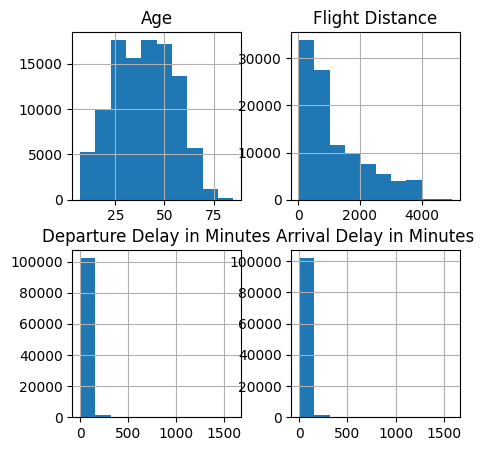

In [20]:
numerical_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

df_train[numerical_cols].hist(figsize = (5,5))
plt.tight_layout
plt.show()

Nota: Aunque hayamos seleccionado las columnas manualmente, existe un pipeline que las distribuirá en función de si son númericas, categóricas o binarias

### 3. Pipelines

#### 3.1. Pipeline para limpiar nulos y duplicados

In [21]:
# Limpieza de nulos y duplicados
class DropHighNullColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.15):
        self.threshold = threshold
        self.cols_to_drop = []
    
    def fit(self, X, y=None):
        null_percentage = X.isnull().mean()
        self.cols_to_drop = null_percentage[null_percentage > self.threshold].index.tolist()
        return self
    
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors="ignore")

class DropRemainingNulls(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dropna()

class DropDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop_duplicates()

null_pipeline = Pipeline([
    ("drop_high_nulls", DropHighNullColumns(threshold=0.15)),
    ("drop_remaining_nulls", DropRemainingNulls()),
    ("drop_duplicates", DropDuplicates())
])

df_train_cleaned = null_pipeline.fit_transform(df_train)
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 70172 to 62567
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  object 
 1   Customer Type                      103594 non-null  object 
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  object 
 4   Class                              103594 non-null  object 
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    103594

### 3.2. Identificación de tipos de columnas

In [22]:
# Identificación de tipos de columnas
class IdentifyColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.numerical_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
        self.binary_cols = [col for col in X.select_dtypes(include=['object']).columns if X[col].nunique() == 2]
        if 'satisfaction' in self.binary_cols:
            self.binary_cols.remove('satisfaction')
        self.target = 'satisfaction'
        self.onehot_cols = [col for col in X.columns if col not in self.numerical_cols and col not in self.binary_cols and col != self.target]
        self.numerical_cols_log = [col for col in self.numerical_cols if col != 'Age']
        return self

    def transform(self, X):
        return X

identify_columns_pipeline = IdentifyColumns()
identify_columns_pipeline.fit(df_train_cleaned)

numerical_cols_log = identify_columns_pipeline.numerical_cols_log
binary_cols = identify_columns_pipeline.binary_cols
onehot_cols = identify_columns_pipeline.onehot_cols
numerical_cols = identify_columns_pipeline.numerical_cols

print(f'Tipos de columnas identificadas correctamente.')

Tipos de columnas identificadas correctamente.


#### 3.3. Pipeline para transformar las columnas numéricas con logaritmo

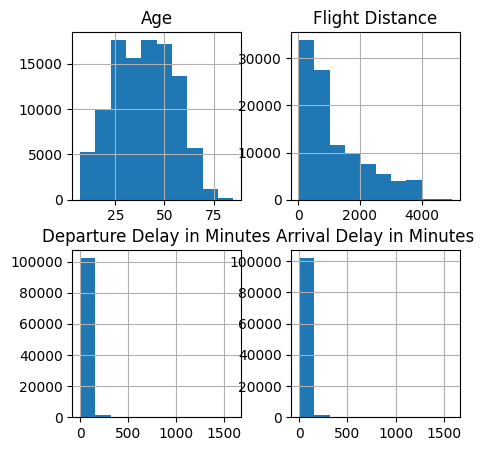

In [23]:
# Aplicar Logaritmo a Variables Numéricas
def safe_log_transform(X):
    """Aplica np.log1p() solo a las columnas numéricas seleccionadas."""
    X = X.copy()
    if isinstance(X, pd.DataFrame):
        for col in numerical_cols_log:
            X[col] = pd.to_numeric(X[col], errors="coerce")  # Convertir a float
            X[col] = np.log1p(X[col])  # Aplicar log1p
    else:
        X = np.log1p(X.astype(float))  # Para arrays numpy

    return X

log_pipeline = FunctionTransformer(safe_log_transform)
df_train_cleaned[numerical_cols_log] = log_pipeline.fit_transform(df_train_cleaned[numerical_cols_log])

df_train[numerical_cols].hist(figsize = (5,5))
plt.tight_layout
plt.show()

### 3.4 Pipeline para transformar las columnas con one hot encoding y estandarizar

In [24]:
# One hot encoding y estandarización
def label_encode_binary(X):
    X_encoded = X.copy()
    for col in X_encoded.columns:
        X_encoded[col] = X_encoded[col].astype("category").cat.codes
    return X_encoded

def binarize_satisfaction(X):
    return X.replace({"neutral or dissatisfied": 0, "satisfied": 1}).infer_objects(copy=False)


preprocessor = ColumnTransformer([
    ("target", FunctionTransformer(binarize_satisfaction), ["satisfaction"]),
    ("binary", FunctionTransformer(label_encode_binary), binary_cols),
    ("onehot", Pipeline([
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ("svd", TruncatedSVD(n_components=50))  # Reduce dimensiones para evitar MemoryError
    ]), onehot_cols),
    ("scaler", StandardScaler(), numerical_cols)
], remainder='passthrough')

preprocessing_pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

df_train_transformed = preprocessing_pipeline.fit_transform(df_train_cleaned)
print(f'Columnas transformadas y estandarizadas.')

C:\Users\mario\AppData\Local\Temp\ipykernel_8012\957567666.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace({"neutral or dissatisfied": 0, "satisfied": 1}).infer_objects(copy=False)


Columnas transformadas y estandarizadas.


### 3.5. Pipeline de entrenamiento y selección del mejor modelo

In [25]:
# Train_test_split
train_set, val_set = train_test_split(df_train_transformed, test_size=0.2, random_state=42)
X_train = train_set[:, 1:]
y_train = train_set[:, 0]
X_val = val_set[:, 1:]
y_val = val_set[:, 0]

# Entrenamiento y selección del mejor modelo
models = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(),
    "LightGBM": lgb.LGBMClassifier()
}

scores = {}
for model_name, model in models.items():
    pipeline_model = Pipeline([("model", model)])
    pipeline_model.fit(X_train, y_train)
    y_pred = pipeline_model.predict(X_val)
    balanced_acc = balanced_accuracy_score(y_val, y_pred)
    scores[model_name] = balanced_acc
    print(f"{model_name} - Balanced Accuracy: {balanced_acc:.4f}")

best_model_name = max(scores, key=scores.get)
print(f"\nModelo seleccionado para optimización: {best_model_name}")

param_grid = {
    "RandomForest": {"model__n_estimators": [50, 100, 200], "model__max_depth": [None, 10, 20]},
    "GradientBoosting": {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1]},
    "LightGBM": {"model__num_leaves": [31, 50], "model__learning_rate": [0.01, 0.1]}
}

grid_search = GridSearchCV(Pipeline([("model", models[best_model_name])]), param_grid[best_model_name], cv=5, scoring="balanced_accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

RandomForest - Balanced Accuracy: 0.9393
GradientBoosting - Balanced Accuracy: 0.9218
LogisticRegression - Balanced Accuracy: 0.9190
[LightGBM] [Info] Number of positive: 35833, number of negative: 47042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13597
[LightGBM] [Info] Number of data points in the train set: 82875, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432374 -> initscore=-0.272172
[LightGBM] [Info] Start training from score -0.272172


c:\Users\mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM - Balanced Accuracy: 0.9431

Modelo seleccionado para optimización: LightGBM


c:\Users\mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 35833, number of negative: 47042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13597
[LightGBM] [Info] Number of data points in the train set: 82875, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432374 -> initscore=-0.272172
[LightGBM] [Info] Start training from score -0.272172


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__num_leaves': [31, 50]},
             scoring='balanced_accuracy')

### 4. Construcción del pipeline y guardado del modelo

In [29]:
# Construcción del pipeline completo
full_pipeline = Pipeline([
    ("null_handling", null_pipeline),
    ("column_identification", identify_columns_pipeline),
    ("log_transform", log_pipeline),
    ("preprocessor", preprocessing_pipeline),
    ("model", grid_search.best_estimator_)
])

# Guardar el pipeline completo con dill
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Sube un nivel al directorio raíz del proyecto
MODEL_DIR = os.path.join(BASE_PATH, "models")

os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, "best_pipeline.pkl")

with open(model_path, "wb") as f:
    dill.dump(full_pipeline, f)

print(f"\nPipeline completo guardado en {model_path}")


Pipeline completo guardado en c:\Users\mario\Documents\GitHub\Pipelines_Airline_Passenger_Satisfaction\src\models\best_pipeline.pkl
